<a href="https://colab.research.google.com/github/Tristan-Brown1096/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [3]:
#checking column headers
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
#reimporting the data to use date-time created column as index
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv', parse_dates=['created'], index_col='created')
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,2,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,41,-74,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1,2,,Columbus Avenue,41,-74,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,41,-74,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,41,-74,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,41,-74,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
import numpy as np
df['all_pets_allowed'] = np.where((df['cats_allowed'] == 1) & (df['dogs_allowed'] == 1), 1, 0)
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,all_pets_allowed
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,2,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,41,-74,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1,2,,Columbus Avenue,41,-74,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2016-04-17 03:26:41,1,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,41,-74,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,41,-74,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,41,-74,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
df['total_rooms'] = df['bathrooms'] + df['bedrooms']
df['bed_bath_ratio'] = df['bedrooms'] / df['bathrooms']
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,all_pets_allowed,total_rooms,bed_bath_ratio
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,2,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,41,-74,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2
2016-06-12 12:19:27,1,2,,Columbus Avenue,41,-74,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2
2016-04-17 03:26:41,1,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,41,-74,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1
2016-04-18 02:22:02,1,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,41,-74,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1
2016-04-28 01:32:41,1,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,41,-74,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,4


In [65]:
df.describe()['bed_bath_ratio']

count   48,513
mean         1
std          1
min          0
25%          1
50%          1
75%          2
max          6
Name: bed_bath_ratio, dtype: float64

In [64]:
df.replace(np.inf, np.nan, inplace=True)
df.describe()

,bathrooms,bedrooms,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,all_pets_allowed,total_rooms,bed_bath_ratio
count,"48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,817","48,513"
mean,1,2,41,-74,"3,580",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1
std,0,1,0,0,"1,762",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
min,0,0,41,-74,"1,375",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,1,1,41,-74,"2,500",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1
50%,1,1,41,-74,"3,150",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1
75%,1,2,41,-74,"4,095",1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2
max,10,8,41,-74,"15,500",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,12,6


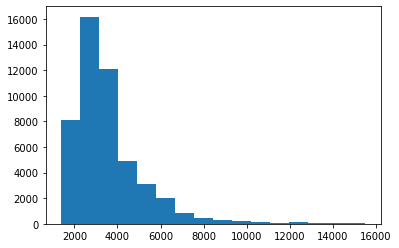

In [23]:
#plotting the frequency of prices
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.hist(df['price'], bins=16)

fig.set_facecolor('w')

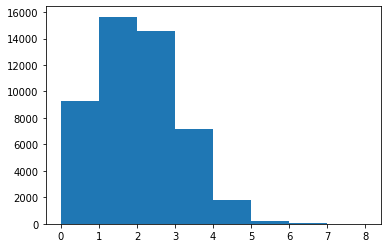

In [26]:
fig, ax = plt.subplots()

plt.hist(df['bedrooms'], bins=8)

fig.set_facecolor('w')

plt.show()

In [82]:
#creating the target vector
y = df['price']

#creating the feature matrix
X = df[['total_rooms', 'pre-war', 'all_pets_allowed']]

In [83]:
#creating cutoff date
cutoff = '2016-06-01'

#creating mask to separate training and validation data
mask = X.index < cutoff

#creating training data
X_train, y_train = X.loc[mask], y.loc[mask]

#creating validation data
X_val, y_val = X.loc[~mask], y.loc[~mask]

In [84]:
#confirming correct separation of data
print(X_train.shape)
print(X_val.shape)
X.shape

(31844, 3)
(16973, 3)


(48817, 3)

In [85]:
X_train.describe()

,total_rooms,pre-war,all_pets_allowed
count,"31,844","31,844","31,844"
mean,3,0,0
std,1,0,0
min,0,0,0
25%,2,0,0
50%,2,0,0
75%,4,0,1
max,12,1,1


In [86]:
#creating baseline guess
def baseline(x=None):
  return y_train.mean()

baseline()

3575.604007034292

[]

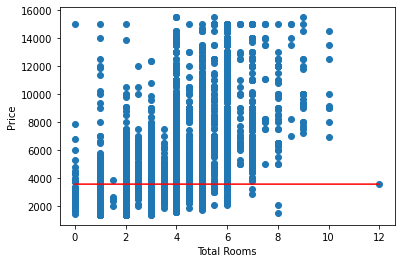

In [87]:
fig, ax = plt.subplots()

x_min, x_max = X_train['total_rooms'].min(), X_train['total_rooms'].max()

x_coords = np.linspace(x_min, x_max, len(X_train))
y_bl_pred = [baseline(x) for x in x_coords]

plt.scatter(X_train['total_rooms'], y_train)
plt.plot(x_coords, y_bl_pred, color='r', label='baseline model')

plt.xlabel('Total Rooms')
plt.ylabel('Price')

fig.set_facecolor('w')

plt.plot()

In [88]:
#testing baseline model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

bl_mae = mean_absolute_error(y_train, y_bl_pred)
bl_rmse = mean_squared_error(y_train, y_bl_pred, squared=False)
bl_r2s = r2_score(y_train, y_bl_pred)

print('Baseline MAE:', bl_mae)
print('Baseline RMSE:', bl_rmse)
print('Baseline r^2:', bl_r2s)

Baseline MAE: 1201.8811133682555
Baseline RMSE: 1762.1090255404863
Baseline r^2: 0.0


In [89]:
#creating model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [91]:
#looking at model coefficients and intecept
print(model.coef_)
model.intercept_

[ 809.16809511 -128.52724462  215.63631717]


1292.7983344101494

In [90]:
#checking the model
y_pred = model.predict(X_train)
model_mae = mean_absolute_error(y_train, y_pred)
model_rmse = mean_squared_error(y_train, y_pred, squared=False)
model_r2s = r2_score(y_train, y_pred)

print('Model MAE:', model_mae)
print('Baseline MAE:', bl_mae)
print('Model RMSE:', model_rmse)
print('Baseline RMSE:', bl_rmse)
print('Model r^2:', model_r2s)
print('Baseline r^2:', bl_r2s)

Model MAE: 885.8246364983991
Baseline MAE: 1201.8811133682555
Model RMSE: 1335.8917546366226
Baseline RMSE: 1762.1090255404863
Model r^2: 0.4252526370539339
Baseline r^2: 0.0


In [93]:
#creating validation model
model_val = LinearRegression()
model_val.fit(X_val, y_val)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [94]:
#checking validation model coefficeints and intercept
print(model_val.coef_)
model_val.intercept_

[ 813.31450001 -144.41006589  226.09162255]


1273.9159632674573

In [92]:
#comparing model values to validation model
y_pred_val = model_val.predict(X_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_rmse = mean_squared_error(y_val, y_pred_val)
val_r2s = r2_score(y_val, y_pred_val)

print('Validation MAE:', val_mae)
print('Model MAE:', model_mae)
print('Validation RMSE:', val_rmse)
print('Model RMSE:', model_rmse)
print('Validation r^2:', val_r2s)
print('Model r^2:', model_r2s)

Validation MAE: 902.6960834008702
Model MAE: 885.8246364983991
Validation RMSE: 1781087.9497318505
Model RMSE: 1335.8917546366226
Validation r^2: 0.4269383005340678
Model r^2: 0.4252526370539339
